# Data Prepration

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)
#
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import RobustScaler
#
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [3]:
# Data Preparation and Inspection

from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/AN2DL_HW_2/training_dataset.zip



Mounted at /content/drive
Archive:  /content/drive/MyDrive/AN2DL_HW_2/training_dataset.zip
  inflating: categories.npy          
  inflating: training_data.npy       
  inflating: valid_periods.npy       


In [4]:
categories = np.load('categories.npy')
training_data = np.load('training_data.npy').astype(np.float32)
valid_periods = np.load('valid_periods.npy')

categories.shape , training_data.shape, valid_periods.shape

((48000,), (48000, 2776), (48000, 2))

In [5]:
def Remove_Zero_Paddings(sequence, valid_period):
    compacted_sequences = []
    for idx, start_idx, end_idx in zip(range(len(sequence)), valid_period[:, 0], valid_period[:, 1]):
        compacted_sequences.append(sequence[idx][start_idx:end_idx])
    return np.array(compacted_sequences)

training_data = Remove_Zero_Paddings(training_data, valid_periods)
training_data.shape

(48000,)

In [6]:
import numpy as np

def replicate_array(original_array, target_length):
    replication_factor = -(-target_length // len(original_array))  # Equivalent to math.ceil(target_length / len(original_array))
    replicated_array = np.tile(original_array, replication_factor)
    return replicated_array[:target_length]

# Example usage:
original_values = np.array([1, 2, 3,1,1])
target_length = 8

replicated_values = replicate_array(original_values, target_length)

print("Original Values:", original_values)
print("Replicated Values:", replicated_values)


Original Values: [1 2 3 1 1]
Replicated Values: [1 2 3 1 1 1 2 3]


In [7]:
all_x = []
all_y = []
all_cats = []
def replicate_array(original_array, target_length):
    replication_factor = -(-target_length // len(original_array))  # Equivalent to math.ceil(target_length / len(original_array))
    replicated_array = np.tile(original_array, replication_factor)
    return replicated_array[:target_length]

def Gen_dataset(data, category, window, stride, telescope):

  short = window + telescope - len(data)

  if (short > 0):
    temp_data = np.concatenate((replicate_array(data,short),data))
  else :
    temp_data = data


  padding_check = (len(temp_data) - window - telescope )  % stride

  if (padding_check !=0):

    padding_len = stride - padding_check
    padding = replicate_array(temp_data,padding_len)
    temp_data = np.concatenate((padding,temp_data))

  for idx in np.arange(0,len(temp_data)-window-telescope + 1,stride):

    all_x.append(temp_data[idx:idx+window])
    all_y.append(temp_data[idx+window:idx+window+telescope])
    all_cats.append(category)

for i in range(len(training_data)):

  Gen_dataset(data=training_data[i], category = categories[i] , window= 200 , stride= 5, telescope=18)

all_x = np.array(all_x)[:, :, np.newaxis]
all_y = np.array(all_y)[:, :, np.newaxis]
all_cats = np.array(all_cats)

all_x.shape, all_y.shape, all_cats.shape


((480885, 200, 1), (480885, 18, 1), (480885,))

In [8]:
del categories
del training_data
del valid_periods

# Transformer Like Model

Model: "encoder_decoder_attention_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 200, 1)]             0         []                            
                                                                                                  
 encoder_lstm (LSTM)         [(None, 200, 128),           66560     ['encoder_input[0][0]']       
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                                  
 dense_1 (Dense)             (None, 200, 128)             16512     ['encoder_lstm[0][0]']        
                                                                    

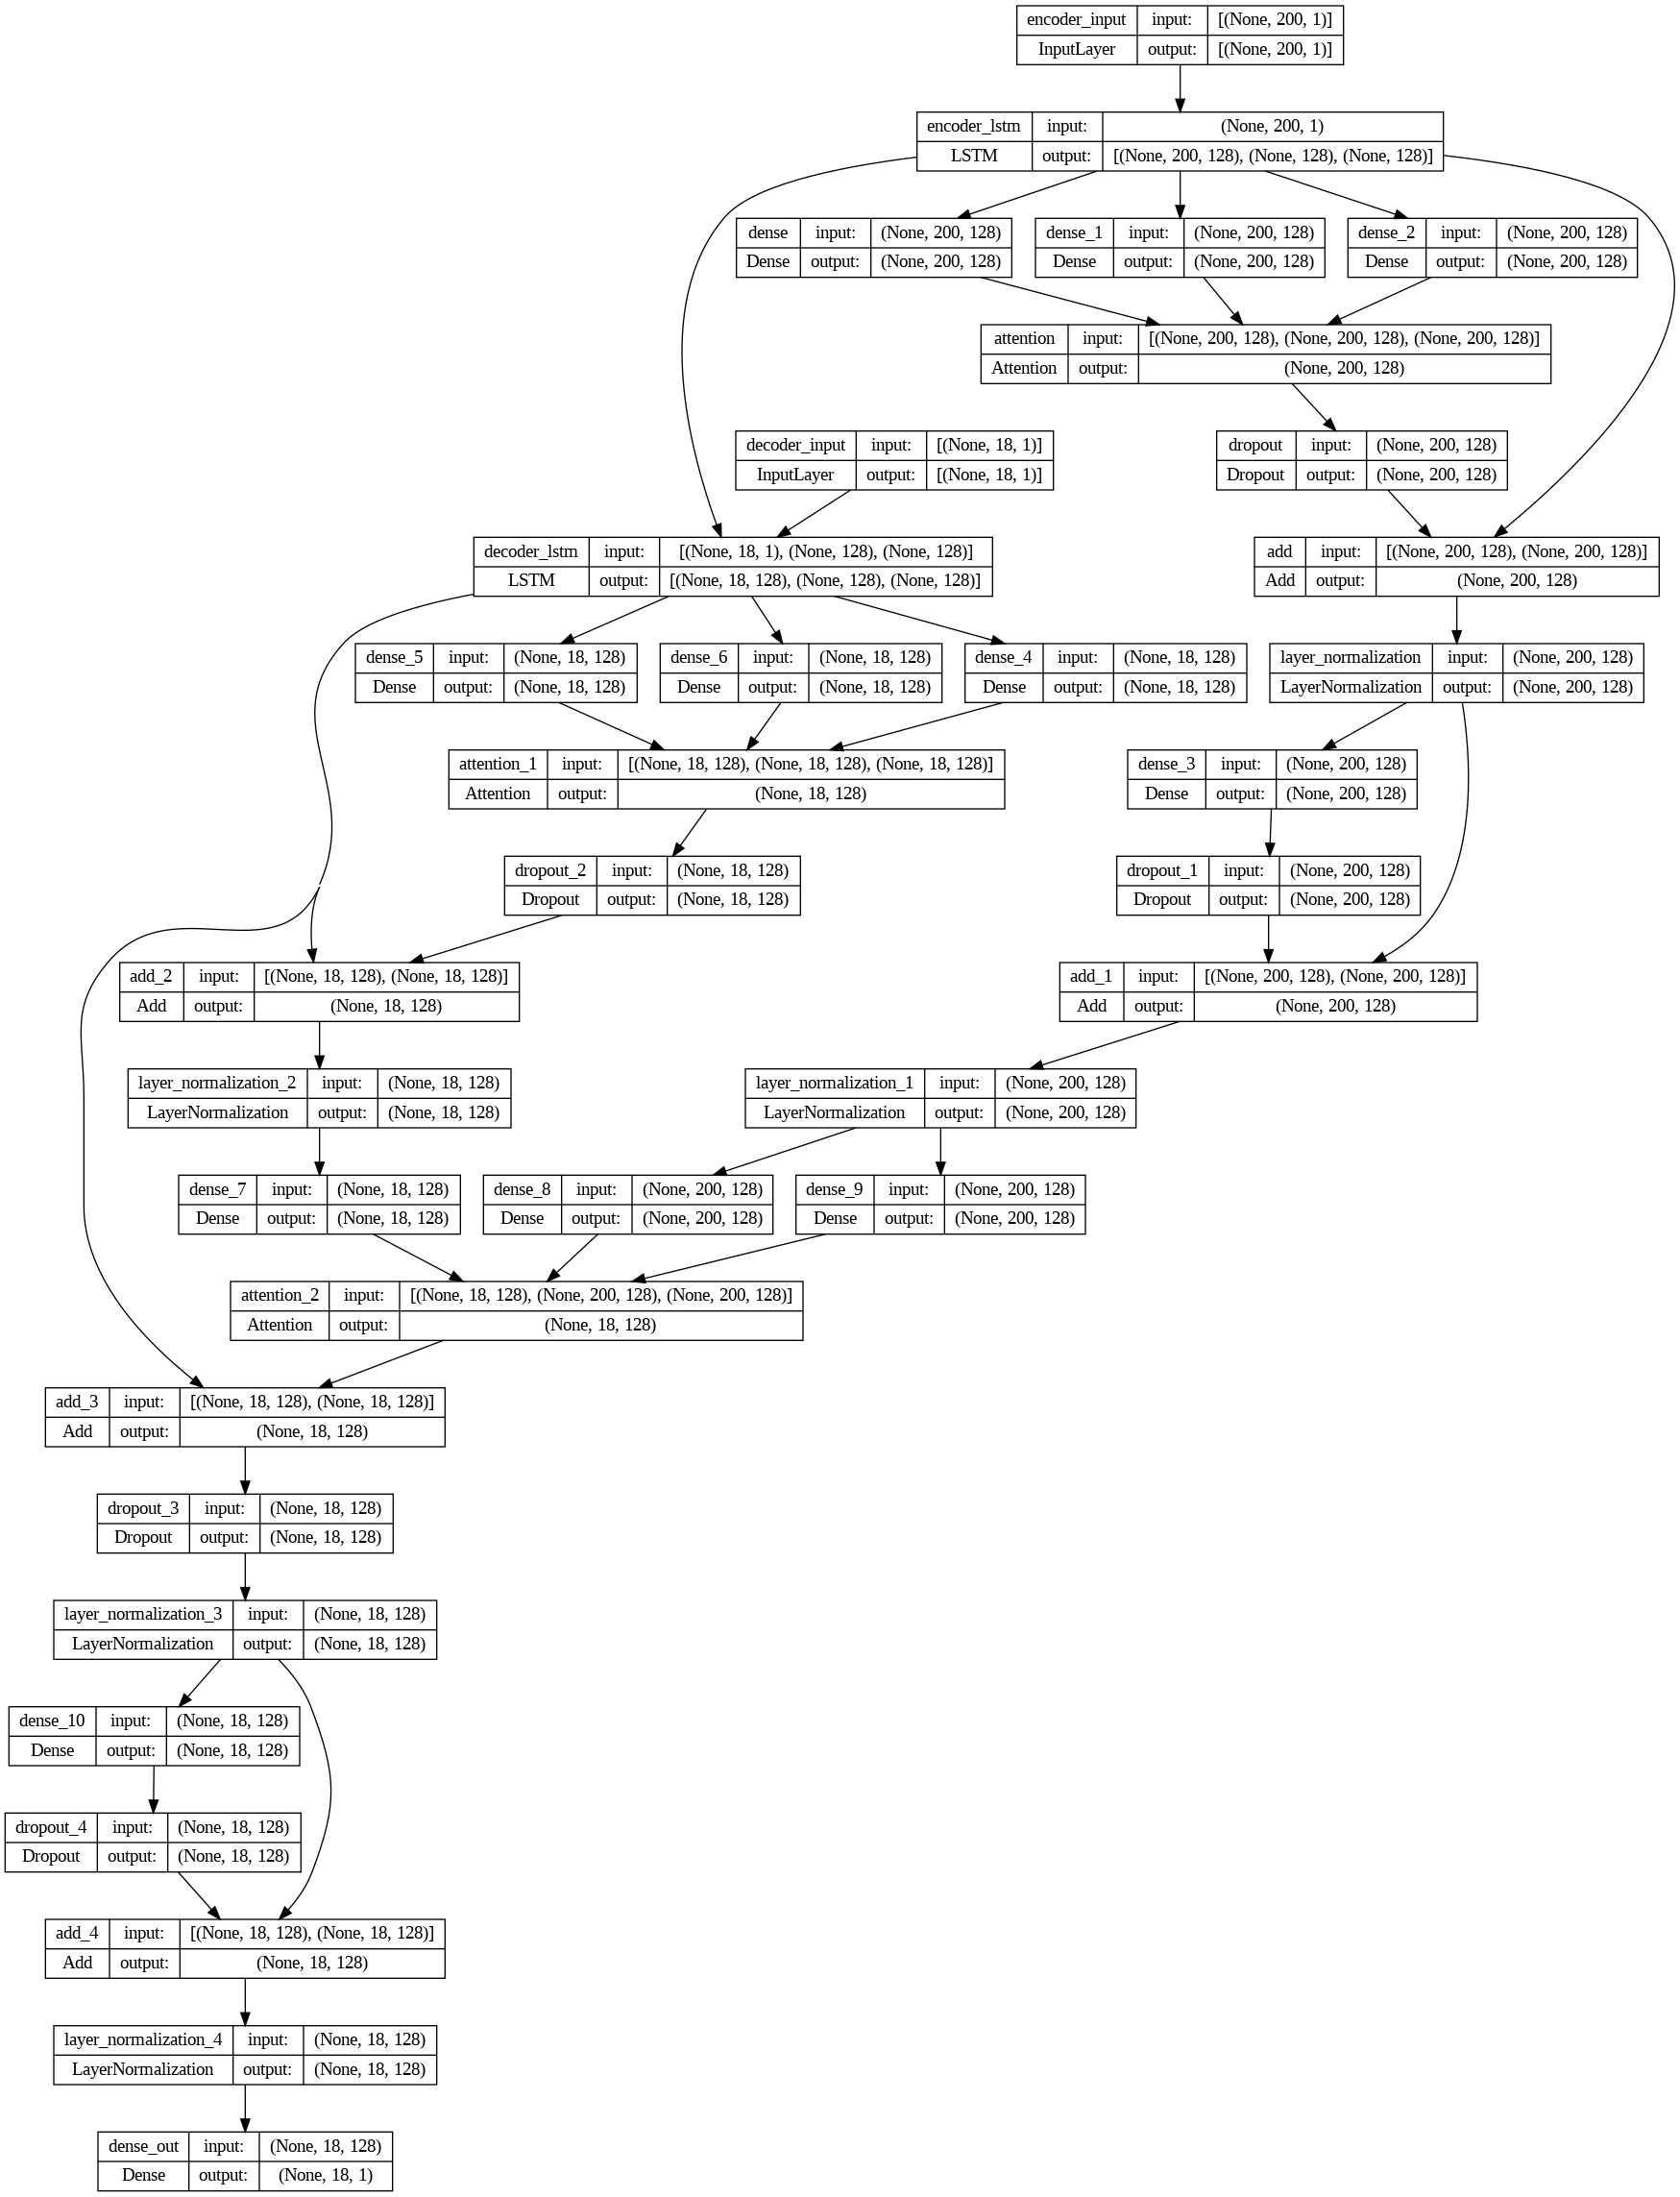

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Add, Concatenate, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

def build_encoder_decoder_attention_model_V_2(input_shape, output_shape, dropout_rate=0.5):
    hidden_dim = 128

    #################
    ##### Encoder####
    #################

    encoder_input = Input(shape=input_shape, name='encoder_input')
    encoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_embs, enc_state_c, enc_state_h = encoder_lstm(encoder_input)

    value_encoder = Dense(hidden_dim, activation='tanh')
    projected_value_encoder = value_encoder(encoder_embs)

    query_encoder = Dense(hidden_dim, activation='tanh')
    projected_query_encoder = query_encoder(encoder_embs)

    key_encoder = Dense(hidden_dim, activation='tanh')
    projected_key_encoder = key_encoder(encoder_embs)

    encoder_self_att = Attention()([projected_query_encoder, projected_key_encoder, projected_value_encoder])
    encoder_self_att = Dropout(rate=dropout_rate)(encoder_self_att, training=True)  # Dropout during training only
    addition_attention_residual = Add()([encoder_embs, encoder_self_att])
    first_normalization_encoder = LayerNormalization()(addition_attention_residual)

    feed_forward_encoder = Dense(hidden_dim, activation='relu')
    encoder_enriched = feed_forward_encoder(first_normalization_encoder)
    encoder_enriched = Dropout(rate=dropout_rate)(encoder_enriched, training=True)  # Dropout during training only

    addition_second_encoder = Add()([first_normalization_encoder, encoder_enriched])
    encoder_output = LayerNormalization()(addition_second_encoder)

    #################
    ##### Decoder####
    #################

    decoder_input = Input(shape=output_shape, name='decoder_input')
    decoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_embs, _, _ = decoder_lstm(decoder_input, initial_state=[enc_state_h, enc_state_c])

    value_decoder = Dense(hidden_dim, activation='tanh')
    projected_value_decoder = value_decoder(decoder_embs)

    query_decoder = Dense(hidden_dim, activation='tanh')
    projected_query_decoder = query_decoder(decoder_embs)

    key_decoder = Dense(hidden_dim, activation='tanh')
    projected_key_decoder = key_decoder(decoder_embs)

    decoder_self_att = Attention()([projected_query_decoder, projected_key_decoder, projected_value_decoder])
    decoder_self_att = Dropout(rate=dropout_rate)(decoder_self_att, training=True)  # Dropout during training only
    first_addition_decoder = Add()([decoder_embs, decoder_self_att])
    first_normalization_decoder = LayerNormalization()(first_addition_decoder)

    query_cross_att = Dense(hidden_dim, activation='tanh')
    projected_query_cross = query_cross_att(first_normalization_decoder)

    value_cross_att = Dense(hidden_dim, activation='tanh')
    projected_value_cross = value_cross_att(encoder_output)

    key_cross_att = Dense(hidden_dim, activation='tanh')
    projected_key_cross = key_cross_att(encoder_output)

    cross_att = Attention()([projected_query_cross, projected_key_cross, projected_value_cross])
    decoder_attended_context = Add()([decoder_embs, cross_att])
    decoder_attended_context = Dropout(rate=dropout_rate)(decoder_attended_context, training=True)  # Dropout during training only

    second_normalization_decoder = LayerNormalization()(decoder_attended_context)

    ffn_decoder = Dense(hidden_dim, activation='relu')
    enriched_decoder = ffn_decoder(second_normalization_decoder)
    enriched_decoder = Dropout(rate=dropout_rate)(enriched_decoder, training=True)  # Dropout during training only

    third_addition_decoder = Add()([enriched_decoder, second_normalization_decoder])
    decoder_output = LayerNormalization()(third_addition_decoder)

    dense_out = Dense(1, activation='sigmoid', name='dense_out')
    final_output = dense_out(decoder_output)

    model = Model([encoder_input, decoder_input], final_output, name='encoder_decoder_attention_model')
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='MSE')

    return model


# Build the model
input_shape = all_x.shape[1:]
output_shape = all_y.shape[1:]
model = build_encoder_decoder_attention_model_V_2(input_shape, output_shape)

# Compile the model

model.summary()
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(all_x, all_y, test_size=0.1, random_state=42)

y_train_dec_in = np.random.rand(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2])
#y_train_dec_in = X_train[:,-18:,:]

# first_elements = X_train[:, -1, 0].reshape(X_train.shape[0], 1, 1)
# remaining_elements = Y_train[:, :-1, 0].reshape(Y_train.shape[0], Y_train.shape[1] - 1, 1)
# y_train_dec_in = np.concatenate((first_elements, remaining_elements), axis=1)

y_train_dec_in.shape , Y_train.shape , X_train.shape

((432796, 18, 1), (432796, 18, 1), (432796, 200, 1))

In [ ]:
#change the batch size and also give the decoder the random noise

In [ ]:
history = model.fit(
    x=[X_train, y_train_dec_in],
    y=Y_train,
    batch_size=128,
    epochs=150,
    validation_split=.2,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, min_delta=0.0001),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history


Epoch 1/150
2705/2705 [==============================] - 138s 45ms/step - loss: 0.0160 - val_loss: 0.0123 - lr: 0.0010
Epoch 2/150
2705/2705 [==============================] - 121s 45ms/step - loss: 0.0120 - val_loss: 0.0116 - lr: 0.0010
Epoch 3/150
2705/2705 [==============================] - 121s 45ms/step - loss: 0.0113 - val_loss: 0.0108 - lr: 0.0010
Epoch 4/150
2705/2705 [==============================] - 121s 45ms/step - loss: 0.0108 - val_loss: 0.0104 - lr: 0.0010
Epoch 5/150
2705/2705 [==============================] - 121s 45ms/step - loss: 0.0105 - val_loss: 0.0104 - lr: 0.0010
Epoch 6/150
2705/2705 [==============================] - 121s 45ms/step - loss: 0.0102 - val_loss: 0.0099 - lr: 0.0010
Epoch 7/150
2705/2705 [==============================] - 121s 45ms/step - loss: 0.0100 - val_loss: 0.0098 - lr: 0.0010
Epoch 8/150
2705/2705 [==============================] - 121s 45ms/step - loss: 0.0099 - val_loss: 0.0097 - lr: 0.0010
Epoch 9/150
2705/2705 [=========================

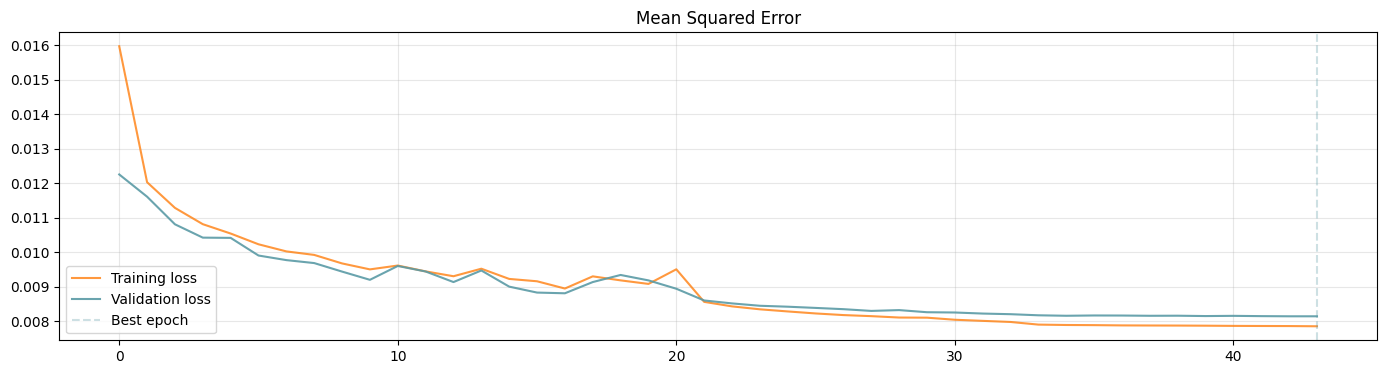

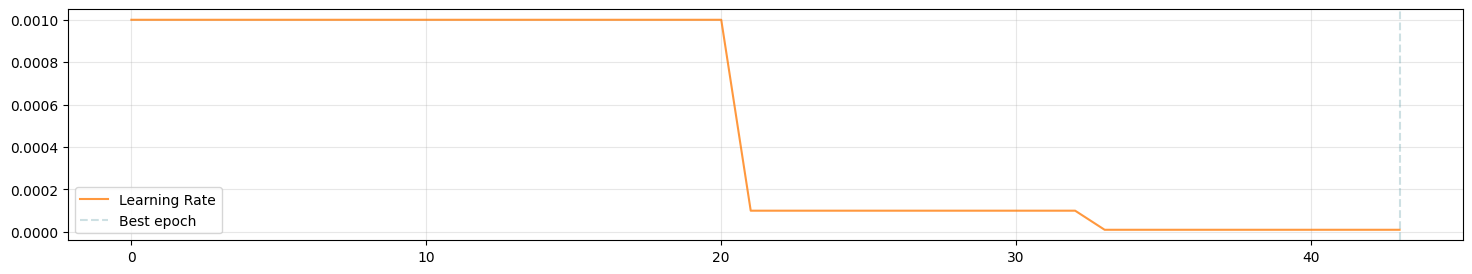

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
Y_hat = model.predict([X_test, np.random.rand(Y_test.shape[0], Y_test.shape[1],Y_test.shape[2])])
#Y_hat = model.predict([X_test, X_test[:,-18:,:]])

1503/1503 [==============================] - 17s 10ms/step


In [ ]:
Y_hat.shape

(48089, 18, 1)

In [ ]:
loss = tfk.losses.MeanSquaredError()
mse = loss(Y_test,Y_hat)
print(mse)

tf.Tensor(0.008319807, shape=(), dtype=float32)


In [ ]:
model.save('/content/drive/MyDrive/AN2DL_HW_2/Transformer(random_0.0083_datareplicat)')

# A new Model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_6 (Bidirecti  (None, 200, 128)             25728     ['input_7[0][0]']             
 onal)                                                                                            
                                                                                                  
 batch_normalization_14 (Ba  (None, 200, 128)             512       ['bidirectional_6[0][0]']     
 tchNormalization)                                                                                
                                                                                            

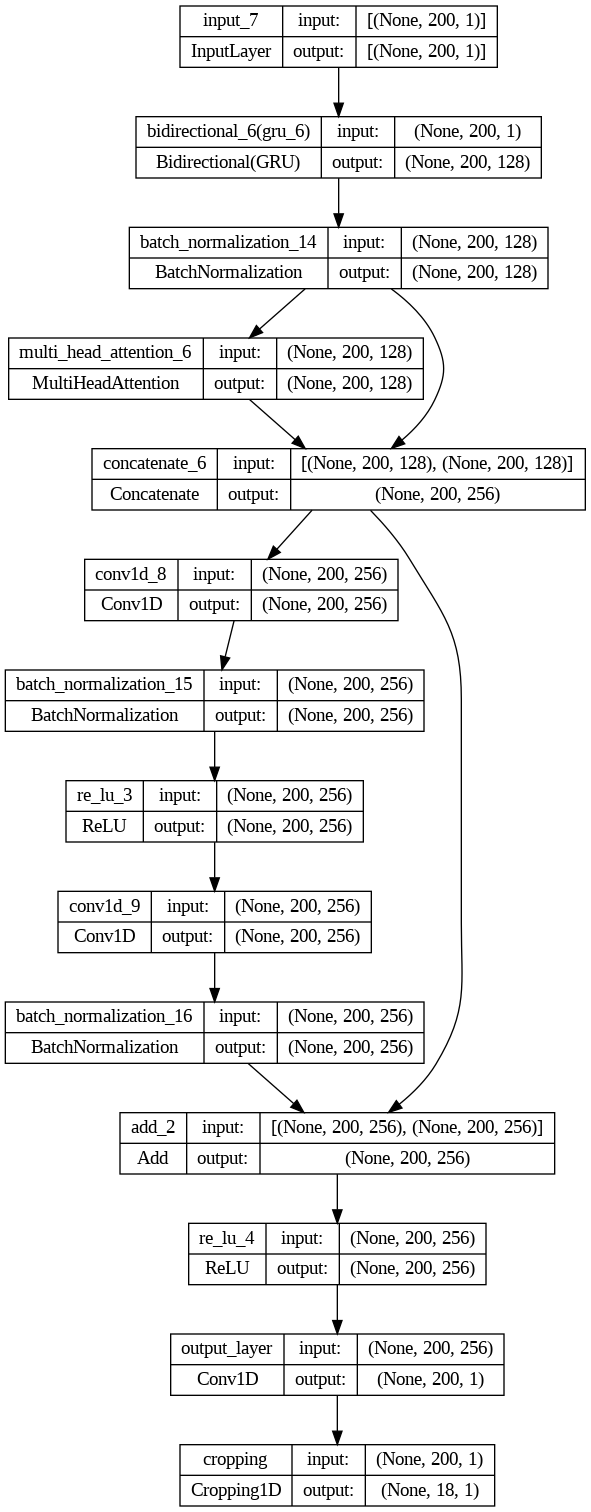

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Cropping1D, Bidirectional, GRU, Input,Conv1D, LSTM, Dense, Attention, Add, Concatenate, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Dropout,BatchNormalization
from tensorflow.keras.models import Model

# Define the residual block
def residual_block(x, filters, kernel_size, dilation_rate):
  shortcut = x

  # First convolution layer
  x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(x)
  x = BatchNormalization()(x)
  x = tfkl.ReLU()(x)

  # Second convolution layer
  x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(x)
  x = BatchNormalization()(x)

  # Adding the shortcut
  x = Add()([x, shortcut])
  x = tfkl.ReLU()(x)
  return x

def build_model(time_series_shape, num_outputs):

  time_series_input = Input(shape=time_series_shape)


  x = Bidirectional(GRU(64, return_sequences=True))(time_series_input)

  x = BatchNormalization()(x)
  attention_output = MultiHeadAttention(num_heads=2, key_dim=128)(x, x)

  x = Concatenate()([x, attention_output])

  x = residual_block(x, filters=256, kernel_size=3, dilation_rate=1)



  output_layer = Conv1D(1, 3, padding="same", name="output_layer")(x)
  crop_size = output_layer.shape[1] - num_outputs
  output_layer = Cropping1D(cropping=(crop_size, 0), name="cropping")(output_layer)

  model = Model(inputs= time_series_input, outputs=output_layer)
  model.compile(loss="mse", optimizer="adam", metrics=["mae"])

  return model

input_shape = all_x.shape[1:]
output_shape = all_y.shape[1]
model = build_model(input_shape, output_shape)

# Compile the model

model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)



In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(all_x, all_y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((432796, 200, 1), (48089, 200, 1), (432796, 18, 1), (48089, 18, 1))

In [ ]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=128,
    epochs=150,
    validation_split=.2,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, min_delta=0.0001),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history


Epoch 1/150
2705/2705 [==============================] - 238s 86ms/step - loss: 0.0253 - mae: 0.0983 - val_loss: 0.0145 - val_mae: 0.0863 - lr: 0.0010
Epoch 2/150
2705/2705 [==============================] - 206s 76ms/step - loss: 0.0135 - mae: 0.0823 - val_loss: 0.0122 - val_mae: 0.0769 - lr: 0.0010
Epoch 3/150
2705/2705 [==============================] - 206s 76ms/step - loss: 0.0118 - mae: 0.0748 - val_loss: 0.0127 - val_mae: 0.0801 - lr: 0.0010
Epoch 4/150
2705/2705 [==============================] - 206s 76ms/step - loss: 0.0109 - mae: 0.0710 - val_loss: 0.0105 - val_mae: 0.0688 - lr: 0.0010
Epoch 5/150
2705/2705 [==============================] - 205s 76ms/step - loss: 0.0104 - mae: 0.0686 - val_loss: 0.0104 - val_mae: 0.0692 - lr: 0.0010
Epoch 6/150
2705/2705 [==============================] - 204s 76ms/step - loss: 0.0099 - mae: 0.0663 - val_loss: 0.0115 - val_mae: 0.0763 - lr: 0.0010
Epoch 7/150
2705/2705 [==============================] - 204s 75ms/step - loss: 0.0096 - mae: 

In [21]:
del model

In [ ]:
decoded_sequences = []
for i in range(len(X_test[:60])):

    predictions=[]

    initial_window = X_test[i]

    long_seq = initial_window
    long_seq = np.expand_dims(long_seq,axis=0)

    fake_seq = (X_test[i,-1])*np.ones((1, X_test.shape[2]), dtype='float32')
    zeros = np.zeros((17,1))
    fake_seq = np.concatenate([fake_seq,zeros],axis=0)
    fake_seq = np.expand_dims(fake_seq,axis=0)


    for j in range(18):
        preds = model.predict([long_seq,fake_seq], verbose=0)
        curr_value = preds[0][0]

        curr_value = np.expand_dims(curr_value,axis=0)

        initial_window = np.concatenate([initial_window,curr_value],axis=0)
        predictions.append(curr_value)

        long_seq = initial_window[1+j:]
        long_seq = np.expand_dims(long_seq,axis=0)

        fake_seq = curr_value
        zeros = np.zeros((17,1))
        fake_seq = np.concatenate([fake_seq,zeros],axis=0)
        fake_seq = np.expand_dims(fake_seq,axis=0)


    decoded_sequences.append(predictions)
decoded_sequences = np.array(decoded_sequences)
decoded_sequences = np.squeeze(decoded_sequences , axis = -1)

loss = tfk.losses.MeanSquaredError()
mse = loss(Y_test[:60],decoded_sequences)
print(mse)


In [ ]:
loss = tfk.losses.MeanSquaredError()
mse = loss(Y_test[:60],decoded_sequences)
print(mse)

tf.Tensor(0.05428481, shape=(), dtype=float32)


In [ ]:
del model